- **paper : Understanding deep learning (still) requires rethinking generalization**
    - doi : https://doi.org/10.1145/3446776
    - summary : https://astonishing-antlion-13b.notion.site/Understanding-Deep-Learning-Still-Requires-Rethinking-Generalization-24be61796c428027a62cff00bcf6ddc9?source=copy_link
- **abstract**
    - `Despite their massive size, successful deep artificial neural networks can exhibit a remarkably small gap between training and test performance. Conventional wisdom attributes small generalization error either to properties of the model family or to the regularization techniques used during training.
Through extensive systematic experiments, we show how these traditional approaches fail to explain why large neural networks generalize well in practice. Specifically, our experiments establish that state-of-the-art convolutional networks for image classification trained with stochastic gradient methods easily fit a random labeling of the training data. This phenomenon is qualitatively unaffected by explicit regularization and occurs even if we replace the true images by completely unstructured random noise. We corroborate these experimental findings with a theoretical construction showing that simple depth two neural networks already have perfect finite sample expressivity as soon as the number of parameters exceeds the number of data points as it usually does in practice.
We interpret our experimental findings by comparison with traditional models.
We supplement this republication with a new section at the end summarizing recent progresses in the field since the original version of this paper.`
- https://www.youtube.com/watch?v=fRndY_MoTlU

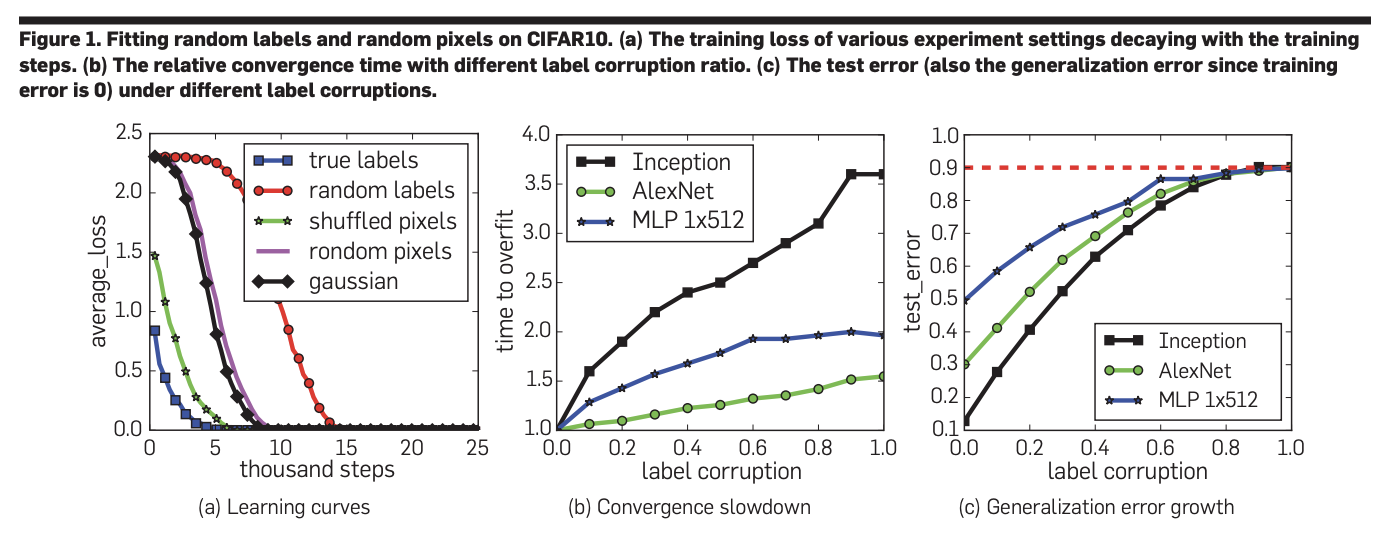

In [51]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import sklearn
import numpy as np

In [52]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print (device)

cuda


In [53]:
transform = transforms.ToTensor() # tensor로 바꿔줘야함
train_DS = datasets.CIFAR10(root='./',
                         train=True,
                         download=True,
                         transform=transform)
test_DS = datasets.CIFAR10(root='./',
                         train=False,
                         download=True,
                         transform=transform)

print (train_DS)
print (test_DS)
print (len(train_DS))
print (len(test_DS))

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./
    Split: Test
    StandardTransform
Transform: ToTensor()
50000
10000


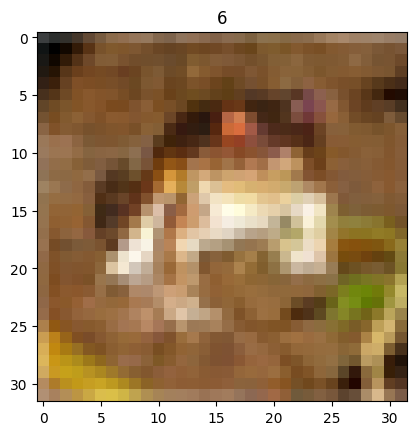

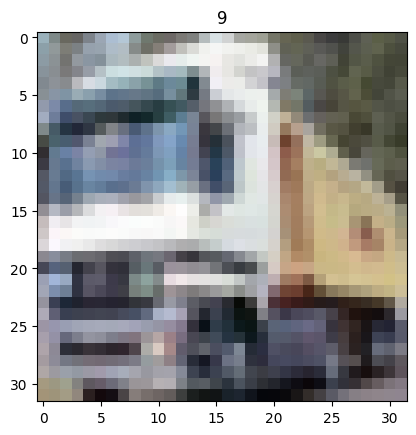

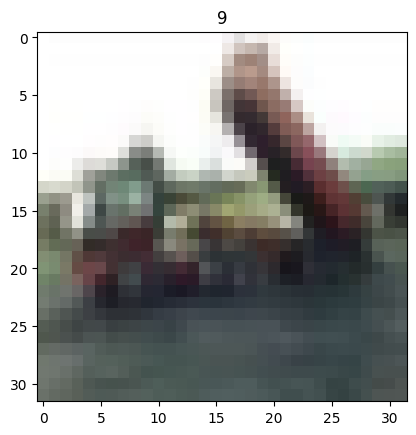

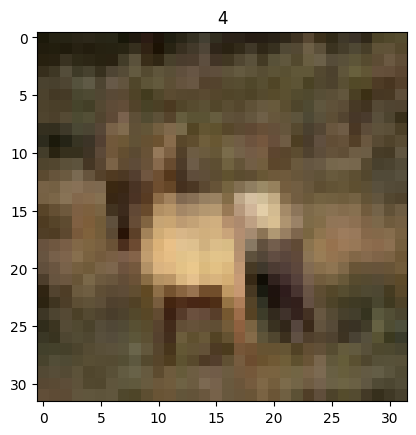

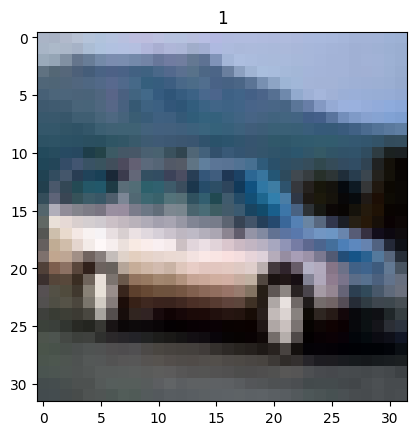

In [54]:
for i in range (5) :
    plt.title(train_DS.targets[i])
    plt.imshow(train_DS.data[i],
          cmap='gray')
    plt.show()

In [55]:
X_train = train_DS.data.copy()
y_train = train_DS.targets.copy()

X_test = test_DS.data.copy()
y_test = test_DS.targets.copy()

print (X_train.shape)

(50000, 32, 32, 3)


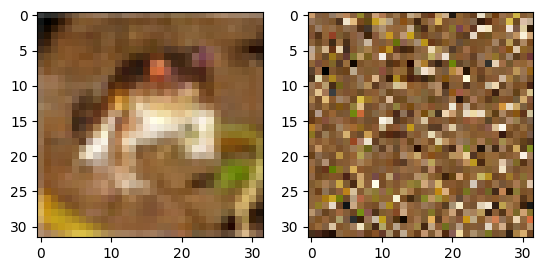

In [56]:
# data manipulation

X_train_shuffled_pixel = X_train.copy()

np.random.seed(42) # FIXED

# shuffle pixels
for i in range(X_train_shuffled_pixel.shape[0]) :
    flat = X_train_shuffled_pixel[i].reshape(-1, 3)
    np.random.shuffle(flat)
    X_train_shuffled_pixel[i] = flat.reshape(32, 32, 3)
plt.subplot(1, 2, 1)
plt.imshow(X_train[0])
plt.subplot(1, 2, 2)
plt.imshow(X_train_shuffled_pixel[0])
plt.show()

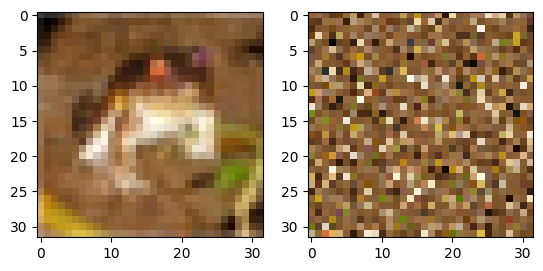

In [57]:
# random pixels

import random

X_train_rand_pixel = X_train.copy()

for i in range(X_train_rand_pixel.shape[0]) :
    np.random.seed(random.randint(1, 1000))
    flat = X_train_rand_pixel[i].reshape(-1, 3)
    np.random.shuffle(flat)
    X_train_rand_pixel[i] = flat.reshape(32, 32, 3)
plt.subplot(1, 2, 1)
plt.imshow(X_train[0])
plt.subplot(1, 2, 2)
plt.imshow(X_train_rand_pixel[0])
plt.show()

In [58]:
# random labels

y_train_rand = y_train.copy()
np.random.shuffle(y_train_rand)

120.70756512369792 64.15007589112135


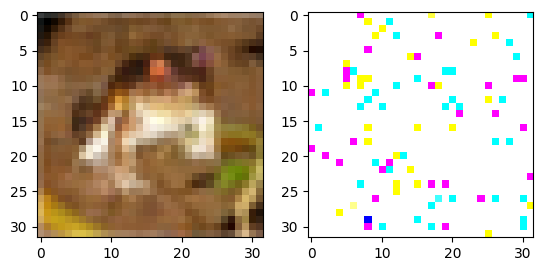

In [59]:
# Gaussian

original_mean = np.mean(X_train)  # 전체 픽셀의 평균
original_std = np.std(X_train)    # 전체 픽셀의 표준편차
print (original_mean, original_std)

X_train_gaussian = np.random.normal(
   loc=original_mean,
   scale=original_std,
   size=X_train.shape
)

X_train_gaussian = np.clip(X_train_gaussian, 0, 255)
plt.subplot(1, 2, 1)
plt.imshow(X_train[0])
plt.subplot(1, 2, 2)
plt.imshow(X_train_gaussian[0])
plt.show()

In [79]:
# get dataset and dataloader

batch_size = 256
from torch.utils.data import Dataset, DataLoader

class Dataset(Dataset):
    def __init__(self, X, y, transform=None):

        self.X = torch.tensor(X, dtype=torch.float32) / 255.0
        self.y = torch.tensor(y, dtype=torch.long)
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]

        if self.transform:
            x = self.transform(x)

        return x, y

train_DL_gaussian = DataLoader(Dataset(X_train_gaussian, y_train),
                     batch_size=batch_size,
                     shuffle=True)

train_DL_rand_pixel = DataLoader(Dataset(X_train_rand_pixel, y_train),
                     batch_size=batch_size,
                     shuffle=True)

train_DL_rand_label = DataLoader(Dataset(X_train, y_train_rand),
                     batch_size=batch_size,
                     shuffle=True)

train_DL_shuffled_pixel = DataLoader(Dataset(X_train_shuffled_pixel, y_train),
                     batch_size=batch_size,
                     shuffle=True)

train_DL_true = DataLoader(Dataset(X_train, y_train),
                     batch_size=batch_size,
                     shuffle=True)

test_DL = DataLoader(test_DS,
                     batch_size=batch_size,
                     shuffle=True)


print (train_DL_true.dataset)
print (len(train_DL_true))

196


In [61]:
# model
# MLP

!pip install torchinfo

from torchinfo import summary
from torch import nn, optim

class MLP (nn.Module) :
  def __init__ (self) :
    super().__init__()
    self.seq1 = nn.Sequential (
        nn.Linear(32*32*3, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Dropout(0.2),

        nn.Linear(128,128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Dropout(0.1),

        nn.Linear(128, 10)
    )

  def forward(self, x) :
    x = torch.flatten(x, start_dim=1) # flatten (갯수를 보존하고)
    return self.seq1(x)

model = MLP().to(device)
summary(model, input_size=(batch_size, 32*32*3))

Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [256, 10]                 --
├─Sequential: 1-1                        [256, 10]                 --
│    └─Linear: 2-1                       [256, 128]                393,344
│    └─BatchNorm1d: 2-2                  [256, 128]                256
│    └─ReLU: 2-3                         [256, 128]                --
│    └─Dropout: 2-4                      [256, 128]                --
│    └─Linear: 2-5                       [256, 128]                16,512
│    └─BatchNorm1d: 2-6                  [256, 128]                256
│    └─ReLU: 2-7                         [256, 128]                --
│    └─Dropout: 2-8                      [256, 128]                --
│    └─Linear: 2-9                       [256, 10]                 1,290
Total params: 411,658
Trainable params: 411,658
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 105.38
Input size (MB): 3.15
Forwa

In [62]:
# ConvNet

class ConvNet(nn.Module):
    def __init__(self, flattened_size):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.flatten = nn.Flatten()

        self.classifier = nn.Sequential(
            nn.Linear(flattened_size, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Dropout(p=0.1),

            nn.Linear(100, 50),
            nn.BatchNorm1d(50),
            nn.ReLU(),
            nn.Dropout(p=0.1),

            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.maxpool1(x)
        x = self.conv_block2(x)
        x = self.maxpool2(x)
        x = self.conv_block3(x)
        x = self.maxpool3(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

def get_flattened_size(model, input_size=(3, 32, 32)):
  with torch.no_grad():
      x = torch.zeros(1, *input_size).to(device)
      x = model.conv_block1(x)
      x = model.maxpool1(x)
      x = model.conv_block2(x)
      x = model.maxpool2(x)
      x = model.conv_block3(x)
      x = model.maxpool3(x)
      return x.numel()  # batch 제외 전체 요소 수

model_tmp = ConvNet(flattened_size=1).to(device)
flat_size = get_flattened_size(model_tmp)
print(f'Flattened size: {flat_size}')

model = ConvNet(flat_size).to(device)
summary(model, input_size=(batch_size, 3, 32, 32))

Flattened size: 1152


Layer (type:depth-idx)                   Output Shape              Param #
ConvNet                                  [256, 10]                 --
├─Sequential: 1-1                        [256, 32, 32, 32]         --
│    └─Conv2d: 2-1                       [256, 32, 32, 32]         896
│    └─BatchNorm2d: 2-2                  [256, 32, 32, 32]         64
│    └─ReLU: 2-3                         [256, 32, 32, 32]         --
├─MaxPool2d: 1-2                         [256, 32, 15, 15]         --
├─Sequential: 1-3                        [256, 64, 15, 15]         --
│    └─Conv2d: 2-4                       [256, 64, 15, 15]         18,496
│    └─BatchNorm2d: 2-5                  [256, 64, 15, 15]         128
│    └─ReLU: 2-6                         [256, 64, 15, 15]         --
├─MaxPool2d: 1-4                         [256, 64, 7, 7]           --
├─Sequential: 1-5                        [256, 128, 7, 7]          --
│    └─Conv2d: 2-7                       [256, 128, 7, 7]          73,856
│    

In [63]:
# inception

class Inception(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, 1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True)
        )
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, 16, 1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 24, 3, padding=1),
            nn.BatchNorm2d(24),
            nn.ReLU(inplace=True)
        )
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, 16, 1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 24, 5, padding=2),
            nn.BatchNorm2d(24),
            nn.ReLU(inplace=True)
        )
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(in_channels, 24, 1),
            nn.BatchNorm2d(24),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return torch.cat([
            self.branch1(x),
            self.branch2(x),
            self.branch3(x),
            self.branch4(x)
        ], dim=1)

class InceptionNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.inception1 = Inception(64)
        self.maxpool = nn.MaxPool2d(2)
        self.inception2 = Inception(88)  # 16+24+24+24=88 channels output from inception
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(88, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(100, 10)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.inception1(x)
        x = self.maxpool(x)
        x = self.inception2(x)
        x = self.avgpool(x)
        x = self.classifier(x)
        return x

model = InceptionNet().to(device)
summary(model, input_size=(batch_size, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
InceptionNet                             [256, 10]                 --
├─Sequential: 1-1                        [256, 64, 32, 32]         --
│    └─Conv2d: 2-1                       [256, 64, 32, 32]         1,792
│    └─BatchNorm2d: 2-2                  [256, 64, 32, 32]         128
│    └─ReLU: 2-3                         [256, 64, 32, 32]         --
├─Inception: 1-2                         [256, 88, 32, 32]         --
│    └─Sequential: 2-4                   [256, 16, 32, 32]         --
│    │    └─Conv2d: 3-1                  [256, 16, 32, 32]         1,040
│    │    └─BatchNorm2d: 3-2             [256, 16, 32, 32]         32
│    │    └─ReLU: 3-3                    [256, 16, 32, 32]         --
│    └─Sequential: 2-5                   [256, 24, 32, 32]         --
│    │    └─Conv2d: 3-4                  [256, 16, 32, 32]         1,040
│    │    └─BatchNorm2d: 3-5             [256, 16, 32, 32]         32
│    

true
X_batch shape: torch.Size([256, 32, 32, 3]), y_batch shape: torch.Size([256])
epoch 100 : train_loss 6.6341
epoch 200 : train_loss 3.9618
epoch 300 : train_loss 2.3402
epoch 400 : train_loss 1.8919
epoch 500 : train_loss 1.2048
epoch 600 : train_loss 1.5460
epoch 700 : train_loss 1.5267
epoch 800 : train_loss 1.0739
epoch 900 : train_loss 0.9704
epoch 1000 : train_loss 1.0121
random_pixel
X_batch shape: torch.Size([256, 32, 32, 3]), y_batch shape: torch.Size([256])
epoch 100 : train_loss 46.7742
epoch 200 : train_loss 25.7646
epoch 300 : train_loss 17.6178
epoch 400 : train_loss 14.1182
epoch 500 : train_loss 13.1917
epoch 600 : train_loss 10.3444
epoch 700 : train_loss 10.6784
epoch 800 : train_loss 9.1999
epoch 900 : train_loss 7.5045
epoch 1000 : train_loss 7.8047
random_label
X_batch shape: torch.Size([256, 32, 32, 3]), y_batch shape: torch.Size([256])
epoch 100 : train_loss 109.2047
epoch 200 : train_loss 65.5082
epoch 300 : train_loss 47.1953
epoch 400 : train_loss 36.4618
e

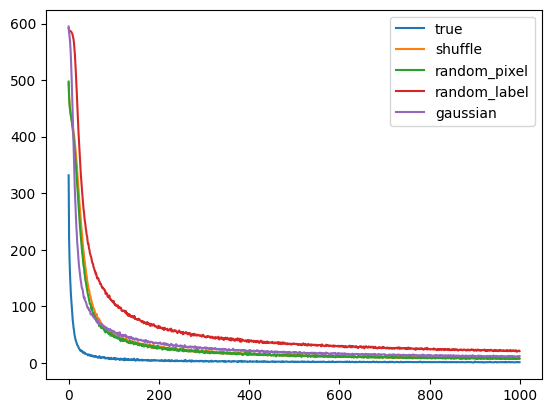

In [64]:
'''
  experiment 1.
  ConvNet을 이용하여 5가지 manipulated data 학습
'''

train_losses = {
    'true' : [],
    'random_pixel' : [],
    'random_label' : [],
    'shuffled_pixel' : [],
    'gaussian' : []
}

epoch = 1000

for i in range (5) :
  train_DL = 0
  key = 0

  match(i) :
    case 0 :
      train_DL = train_DL_true
      key = 'true'
    case 1 :
      train_DL = train_DL_rand_pixel
      key = 'random_pixel'
    case 2 :
      train_DL = train_DL_rand_label
      key = 'random_label'
    case 3 :
      train_DL = train_DL_shuffled_pixel
      key = 'shuffled_pixel'
    case 4 :
      train_DL = train_DL_gaussian
      key = 'gaussian'

  print (key)
  for X_batch, y_batch in train_DL:
    print(f'X_batch shape: {X_batch.shape}, y_batch shape: {y_batch.shape}')
    break

  model = ConvNet(1152).to(device)
  optimizer = optim.Adam(model.parameters(), lr=0.001)
  criterion = nn.CrossEntropyLoss()

  for ep in range (epoch) :
    train_loss = 0
    N = 0
    for X_batch, y_batch in train_DL :
        N += 1
        # inference
        X_batch = X_batch.permute(0, 3, 1, 2).to(device)
        y_batch = y_batch.to(device)
        y_hat = model(X_batch)

        # loss
        loss = criterion (y_hat, y_batch)
        train_loss += loss.item() * X_batch.size(0)

        # deriviate
        optimizer.zero_grad()
        loss.backward()

        # update
        optimizer.step()

    train_losses[key].append (train_loss / N)

    if (ep + 1) % 100 == 0 :
      print (f'epoch {ep+1} : train_loss {train_loss/N:.4f}')

plt.plot(train_losses['true'], label='true')
plt.plot(train_losses['shuffled_pixel'], label='shuffle')
plt.plot(train_losses['random_pixel'], label='random_pixel')
plt.plot(train_losses['random_label'], label='random_label')
plt.plot(train_losses['gaussian'], label='gaussian')
plt.legend()
plt.show()

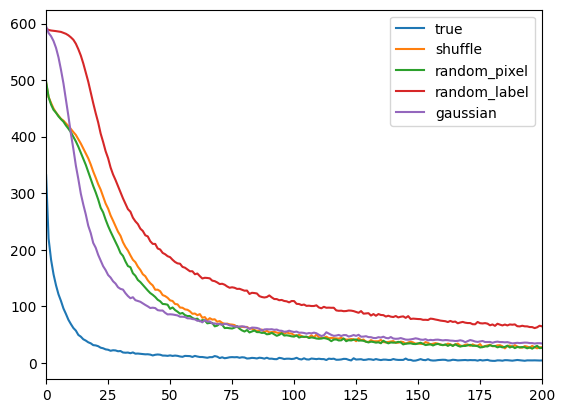

In [71]:
plt.plot(train_losses['true'], label='true')
plt.plot(train_losses['shuffled_pixel'], label='shuffle')
plt.plot(train_losses['random_pixel'], label='random_pixel')
plt.plot(train_losses['random_label'], label='random_label')
plt.plot(train_losses['gaussian'], label='gaussian')
plt.xlim(0, 200)
plt.legend()
plt.show()

MLP TIME
epoch 1, running loss 1.7285
epoch 2, running loss 1.5235
epoch 3, running loss 1.4451
epoch 4, running loss 1.3921
epoch 5, running loss 1.3463
epoch 6, running loss 1.3169
epoch 7, running loss 1.2895
epoch 8, running loss 1.2646
epoch 9, running loss 1.2364
epoch 10, running loss 1.2227
epoch 11, running loss 1.2013
epoch 12, running loss 1.1852
epoch 13, running loss 1.1636
epoch 14, running loss 1.1541
epoch 15, running loss 1.1324
epoch 16, running loss 1.1247
epoch 17, running loss 1.1091
epoch 18, running loss 1.0964
epoch 19, running loss 1.0818
epoch 20, running loss 1.0705
epoch 21, running loss 1.0629
epoch 22, running loss 1.0512
epoch 23, running loss 1.0411
epoch 24, running loss 1.0305
epoch 25, running loss 1.0248
epoch 26, running loss 1.0117
epoch 27, running loss 1.0082
epoch 28, running loss 0.9961
epoch 29, running loss 0.9911
epoch 30, running loss 0.9804
epoch 31, running loss 0.9686
epoch 32, running loss 0.9659
epoch 33, running loss 0.9524
epoch 34, 

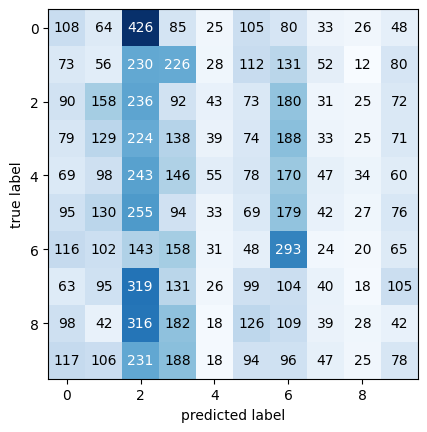

CONVNET TIME
epoch 1, running loss 1.3221
epoch 2, running loss 0.8736
epoch 3, running loss 0.7136
epoch 4, running loss 0.6165
epoch 5, running loss 0.5459
epoch 6, running loss 0.4923
epoch 7, running loss 0.4363
epoch 8, running loss 0.3870
epoch 9, running loss 0.3487
epoch 10, running loss 0.3143
epoch 11, running loss 0.2798
epoch 12, running loss 0.2529
epoch 13, running loss 0.2311
epoch 14, running loss 0.2033
epoch 15, running loss 0.1853
epoch 16, running loss 0.1677
epoch 17, running loss 0.1609
epoch 18, running loss 0.1390
epoch 19, running loss 0.1372
epoch 20, running loss 0.1276
epoch 21, running loss 0.1191
epoch 22, running loss 0.1168
epoch 23, running loss 0.1068
epoch 24, running loss 0.1015
epoch 25, running loss 0.0999
epoch 26, running loss 0.0851
epoch 27, running loss 0.0875
epoch 28, running loss 0.0886
epoch 29, running loss 0.0876
epoch 30, running loss 0.0806
epoch 31, running loss 0.0793
epoch 32, running loss 0.0762
epoch 33, running loss 0.0715
epoch 

RuntimeError: Given groups=1, weight of size [32, 3, 3, 3], expected input[256, 32, 3, 32] to have 3 channels, but got 32 channels instead

In [80]:
'''
  experiment 2.
  모델끼리의 비교
'''

train_DL = train_DL_true

from torch import optim

model_MLP = MLP().to(device)
model_CNN = ConvNet(1152).to(device)
model_Inception = InceptionNet().to(device)

model_losses = {
    'MLP' : [],
    'ConvNet' : [],
    'Inception' : []
}

model_accs = {
    'MLP' : [],
    'ConvNet' : [],
    'Inception' : []
}

for i, model in enumerate([model_MLP, model_CNN, model_Inception]) :
    key = 0
    if i == 0 :
        print ('MLP TIME')
        key = 'MLP'
    elif i == 1 :
        print ('CONVNET TIME')
        key = 'ConvNet'
    else :
        print ("INCEPTION TIME")
        key = 'Inception'

    optimizer = optim.Adam(model.parameters(),
                          lr=0.001)
    critrion = nn.CrossEntropyLoss()
    epoch = 100

    # def train (model,
    #           train_DL,
    #           critrion,
    #           optimizer,
    #           epoch) :
    loss_history = []
    N = len(train_DL.dataset)

    model.train()
    for ep in range (epoch) :
        rloss = 0 # running loss

        for X_batch, y_batch in train_DL :
            X_batch = X_batch.permute(0, 3, 1, 2).to(device)
            y_batch = y_batch.to(device)

            # y_batch = y_batch.argmax(dim=1)  # one-hot -> class index 변환


            # inference
            y_hat = model(X_batch)

#             print(y_hat.shape)
#             print(y_batch.shape)


            # loss
            loss = critrion(y_hat, y_batch)

            # deriviate
            optimizer.zero_grad()
            loss.backward()

            # update
            optimizer.step()

            # loss accumulation
            loss_b = loss.item() * X_batch.shape[0] # batch의 loss
            rloss += loss_b # batch loss의 총합

        running_loss = rloss/N # batch loss 총합 / 전체 데이터 갯수
        loss_history.append (running_loss)

        print (f"epoch {ep+1}, running loss {running_loss:.4f}")
        model_losses[key].append (running_loss)

        all_preds = []
        all_labels = []
        train_acc = 0
        with torch.no_grad() :
            rcorrect = 0
            for X_batch, y_batch in train_DL :
                X_batch = X_batch.permute(0, 3, 1, 2).to(device)
                y_batch = y_batch.to(device)

                # inference
                y_hat = model(X_batch)
                pred = y_hat.argmax(dim=1)

                all_preds.extend(pred.cpu().numpy())
                all_labels.extend(y_batch.cpu().numpy())

                corrects_b = torch.sum(pred == y_batch).item()
                rcorrect += corrects_b
            train_acc = rcorrect / len(train_DL.dataset) * 100

        model_accs[key].append (train_acc)

    # test
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad() :
        rcorrect = 0
        for X_batch, y_batch in test_DL :
            X_batch = X_batch.permute(0, 3, 1, 2).to(device)
            y_batch = y_batch.to(device)

            # inference
            y_hat = model(X_batch) # 이러면 여기엔 logit이 들어와있을것임 softmax니깐
            pred = y_hat.argmax(dim=1) # 레이블 뽑아내기

            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

            corrects_b = torch.sum(pred == y_batch).item()
            # 실제값이랑 예측값이랑 맞는거의 합
            rcorrect += corrects_b
        accuracy_e = rcorrect / len(test_DL.dataset) * 100

    print (f"{key} test acc : {accuracy_e}")

    from sklearn.metrics import classification_report, confusion_matrix

    print("\n[Classification Report]")
    print(classification_report(all_labels, all_preds))

    print("\n[Confusion Matrix]")
    cm = confusion_matrix(all_labels, all_preds)
    print(cm)

    from mlxtend.plotting import plot_confusion_matrix

    fig, ax = plot_confusion_matrix(conf_mat=cm)
    plt.show()

In [1]:
# plt.plot(model_losses['MLP'], label='MLP')
# plt.plot(model_losses['ConvNet'], label='ConvNet')
# plt.plot(model_losses['Inception'], label='Inception')
# plt.legend()
# plt.show()

# plt.plot(model_accs['MLP'], label='MLP')
# plt.plot(model_accs['ConvNet'], label='ConvNet')
# plt.plot(model_accs['Inception'], label='Inception')
# plt.legend()
# plt.show()

NameError: name 'plt' is not defined